In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import datetime

In [2]:
data_path = 'database.csv'

data = pd.read_csv(data_path)

data = data[data['Type'] == 'Earthquake']

bad_cols = ['Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap','Horizontal Distance',
            'Horizontal Error','Root Mean Square', 'Type', 'ID', 'Depth Error', 'Depth Seismic Stations',
            'Date', 'Time']


data['Longitude'] = np.sin(data['Longitude'])
data['Latitude'] = np.sin(data['Latitude'])

data['dt'] = data['Date'] + ' ' + data['Time']


bad_rows = []
for idx in range(len(data)):
    try:
        t = data['dt'][idx]
        if 'T' in t:
            bad_rows += [idx]
    except:
        pass

data = data.drop(bad_rows, axis=0)
data = data.drop(bad_cols, axis=1)

# some stuff to use datetime class
dater = lambda t: datetime.datetime.strptime(t, "%m/%d/%Y %H:%M:%S")
map_time = np.vectorize(dater)
dt = map_time(data['dt'])
epoch = datetime.datetime(1965, 1, 1)
delta = (dt-epoch)

# converting data_time to seconds
map_seconds = np.vectorize(lambda t: t.total_seconds())
data['dt'] = map_seconds(delta)

# converting string classification data to numbers
for item_name in data.dtypes[data.dtypes == 'object'].index.values:
    map_dict = {}
    for item in pd.Series(data[item_name]).unique():
            map_dict[item] = len(map_dict)

    data[item_name].replace(to_replace=map_dict, inplace=True)

data.dropna()

Y = data['Magnitude']
X = data.drop('Magnitude', axis=1)

X.rename(index=str, columns={"Magnitude Type": "Mag_Type",
                             "Location Source": "Location_Source",
                             "Magnitude Source": "Magnitude_Source"
                            }, inplace=True)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)


In [4]:
gbm = xgb.XGBClassifier(max_depth=4, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
predictions = gbm.predict(X_test)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [5]:
print((y_test-predictions).dot(y_test-predictions) / len(y_test))

0.2578995479982785


In [6]:
# so we have accuracy about 0.5 in predictions

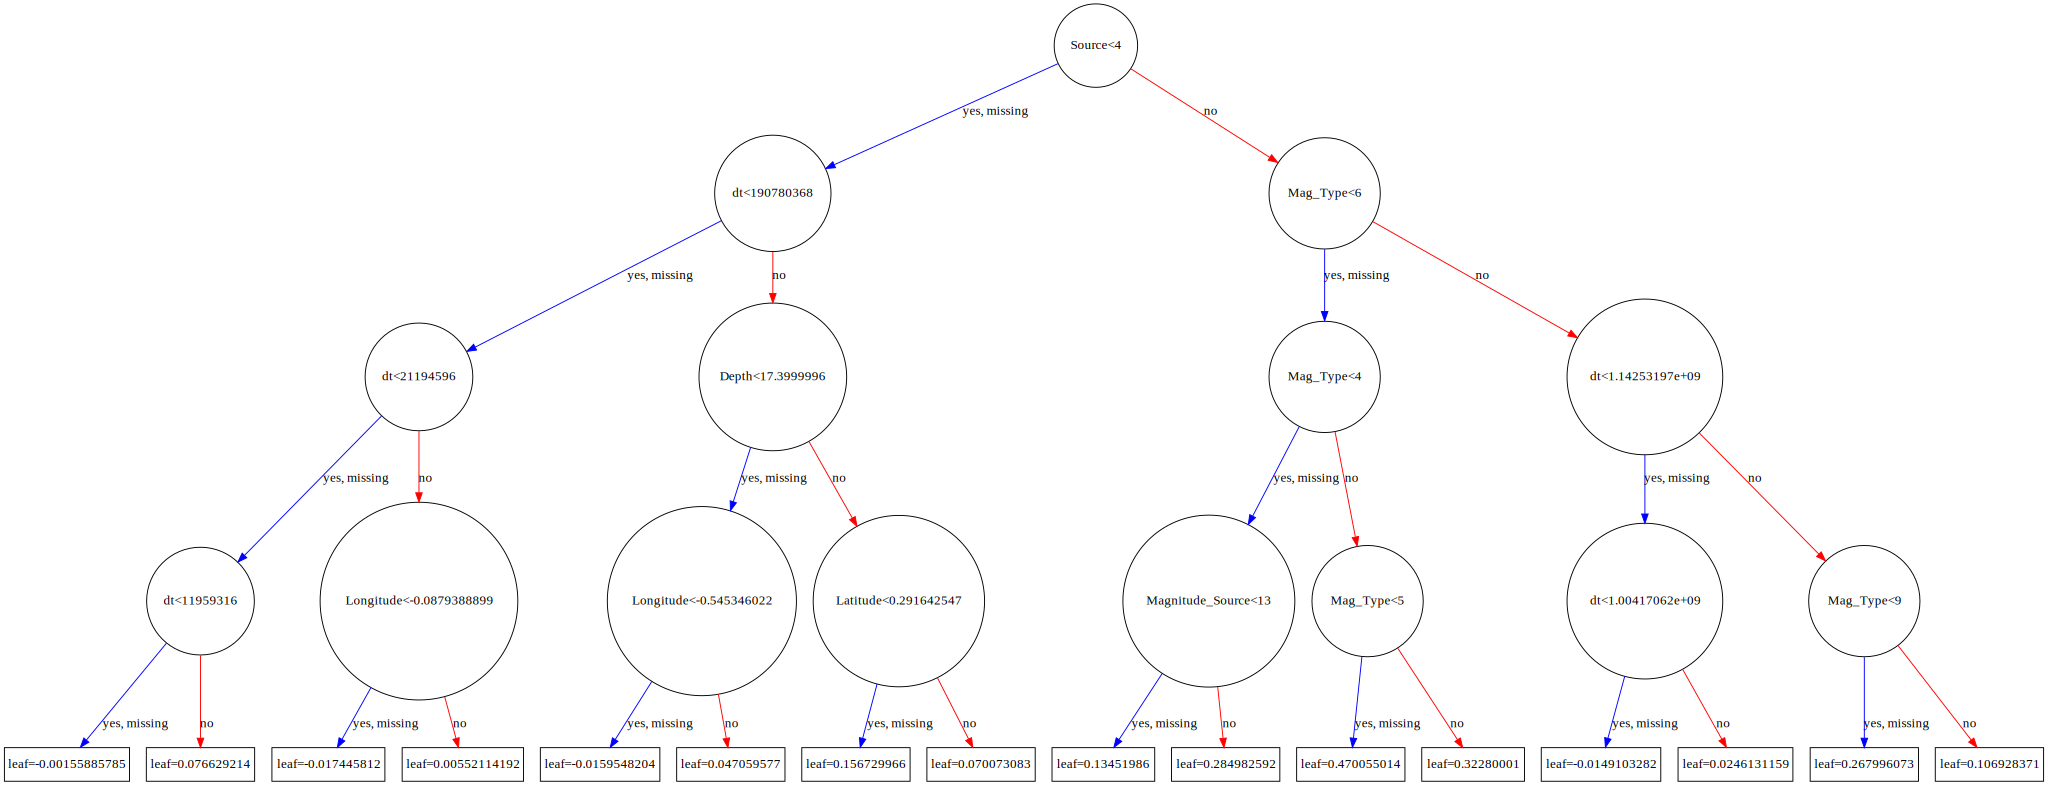

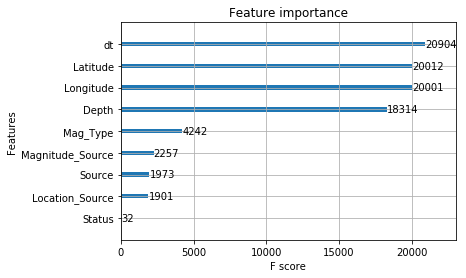

<Figure size 1440x1080 with 0 Axes>

In [18]:
# shows features importance
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
xgb.plot_importance(gbm, ax=plt.gca())

# trees
plt.figure(figsize=(20,15))
# xgb.plot_tree(gbm, ax=plt.gca())
xgb.to_graphviz(gbm)#, num_trees=1000)